Import Datasets

In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


Read datasets

In [4]:
Root = Path(r"C:\Users\daksh\StoreSales")
holidays = pd.read_csv(Root/"holidays_events.csv")
oil = pd.read_csv(Root/"oil.csv")
stores = pd.read_csv(Root/"stores.csv")
transactions = pd.read_csv(Root/"transactions.csv")
train = pd.read_csv(Root/"train.csv")
test = pd.read_csv(Root/"test.csv")


Convert date columns to datetime format

In [5]:
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
test['date'] = pd.to_datetime(test['date'])
train['date'] = pd.to_datetime(train['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

Analysis

In [6]:
# Key Performance indicators
kpi_labels = [
    'Number of Stores',
    'Number of Different Products',
    'Window Start Date',
    'Window End Date',
    '# Rows in Training Set',
    '# Date Points in Train Dataset'
]
kpi_values = [
    train['store_nbr'].nunique(),
    train['family'].nunique(),
    str(train['date'].min().date()),
    str(train['date'].max().date()),
    str(train['id'].max()+1),
    train['date'].nunique()
]
kpi_df = pd.DataFrame({'KPI': kpi_labels, 'Values': kpi_values})
print(kpi_df)

                              KPI      Values
0                Number of Stores          54
1    Number of Different Products          33
2               Window Start Date  2013-01-01
3                 Window End Date  2017-08-15
4          # Rows in Training Set     3000888
5  # Date Points in Train Dataset        1684


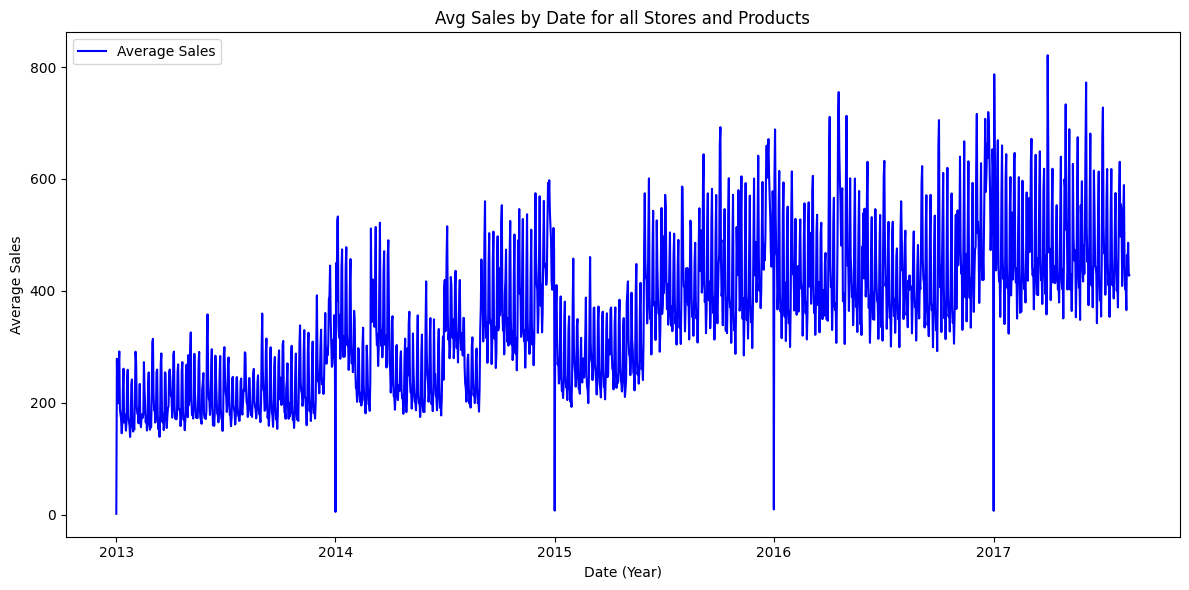

In [7]:
# Computing Average Sales
train_avg = train[['date', 'sales', 'onpromotion']].groupby('date').mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(train_avg['date'], train_avg['sales'], color= 'blue', label='Average Sales')

plt.title('Avg Sales by Date for all Stores and Products')
plt.xlabel('Date (Year)')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.legend()
plt.show()

Overall, sales show an increasing trend.
Over the past two years (since July 2015), the trend has been relatively stable (almost stationary time series).
On January 1st each year, sales drop to zero as supermarkets are closed.

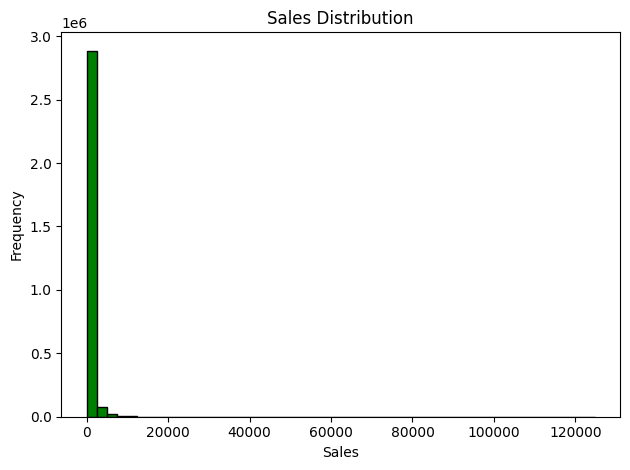

In [8]:
# Sales Distribution
plt.Figure(figsize=(10,5))
plt.hist(train['sales'], bins=50,color='green', edgecolor='black')

plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

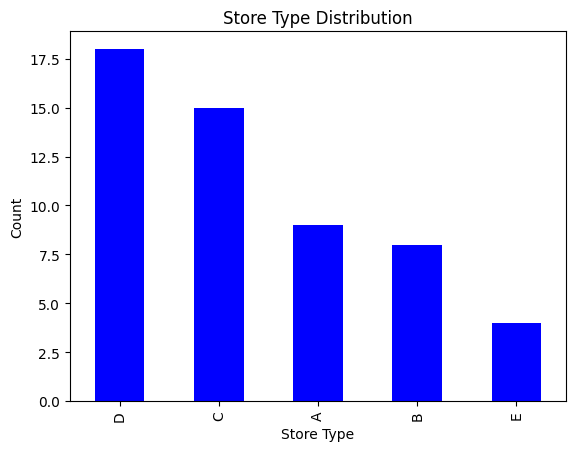

In [9]:
# Store Type Distribution
stores['type'].value_counts().plot(kind='bar', title='Store Type Distribution', color='blue')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()

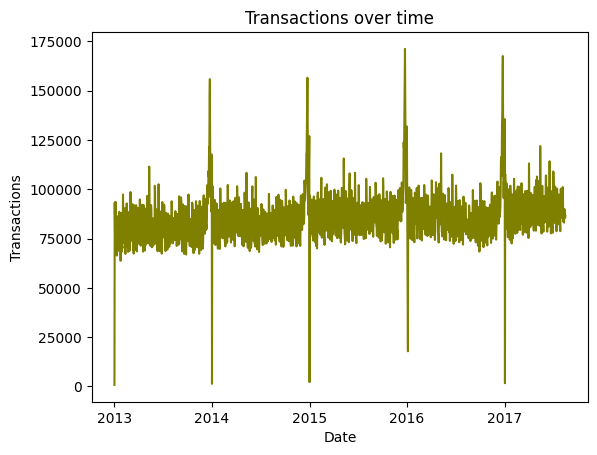

In [10]:
# Transactions over time
trans_by_date = transactions[['date','transactions']].groupby('date').sum().reset_index()
plt.Figure(figsize=(14,6))
plt.plot(trans_by_date['date'], trans_by_date['transactions'], color="olive")
plt.title("Transactions over time")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.show()

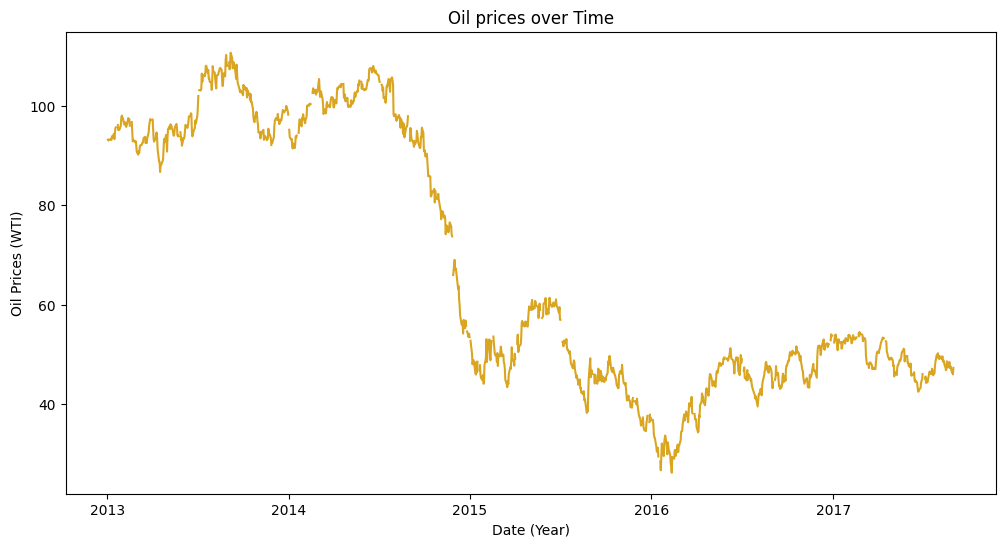

In [11]:
# Oil price over time
oil_price = oil.groupby('date')['dcoilwtico'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(oil['date'],oil['dcoilwtico'], color="goldenrod")
plt.title("Oil prices over Time")
plt.xlabel("Date (Year)")
plt.ylabel("Oil Prices (WTI)")
plt.show()

In [12]:

# Data Engineering and merging datasets
train_full = train.merge(oil, on='date', how='left')
train_full = train_full.merge(stores, on='store_nbr',how='left')
holidays_simple = holidays[['date','type','locale','locale_name','transferred']]
train_full = train_full.merge(holidays_simple, on='date', how='left')
train_full = train_full.merge(transactions,on=['date', 'store_nbr'], how='left')

train_full['date'] = pd.to_datetime(train_full['date'])
train_full['year'] = train_full['date'].dt.year
train_full['month'] = train_full['date'].dt.month
train_full['day'] = train_full['date'].dt.day
train_full['dayofweek'] = train_full['date'].dt.dayofweek   # Monday=0, Sunday=6
train_full['weekofyear'] = train_full['date'].dt.isocalendar().week.astype(int)
train_full['is_weekend'] = (train_full['dayofweek'] >= 5).astype(int)

# Lag Feature
train_full = train_full.sort_values(['store_nbr', 'family', 'date'])
train_full['lag_1'] = train_full.groupby(['store_nbr','family'])['sales'].shift(1)
train_full['lag_7'] = train_full.groupby(['store_nbr','family'])['sales'].shift(7)
train_full['lag_14'] = train_full.groupby(['store_nbr','family'])['sales'].shift(14)
train_full[['date','store_nbr','family','sales','lag_1','lag_7','lag_14']].head(20)

# Rolling Mean
train_full['rolling_mean_7'] = (
    train_full
    .groupby(['store_nbr','family'])['sales']
    .shift(1)                 # shift → excludes today
    .rolling(window=7)        # look at last 7 rows
    .mean()
)
train_full['rolling_mean_30'] = (
    train_full
    .groupby(['store_nbr','family'])['sales']
    .shift(1)
    .rolling(window=30)
    .mean()
)
train_full['transferred'] = train_full['transferred'].fillna(False)
train_full['transferred'] = train_full['transferred'].astype(int)
train_full['transferred'].unique()

C:\Users\daksh\AppData\Local\Temp\ipykernel_14508\2449563191.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_full['transferred'] = train_full['transferred'].fillna(False)


array([0, 1])

In [13]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

le = LabelEncoder()
cat_cols = train_full.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    train_full[col] = le.fit_transform(train_full[col].astype(str))




In [14]:
# Drop rows with NaN (because of lags/rolling means)
train_model = train_full.dropna().copy()

# Feature list (all columns except id, date, sales)
features = [col for col in train_model.columns if col not in ['id', 'date', 'sales']]


In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

X = train_model[features]
y = train_model['sales']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    n_iter_no_change=200,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)]
)


[LightGBM] [Warning] early_stopping_round is set=200, n_iter_no_change=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.860261
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.250292
[LightGBM] [Debug] init for col-wise cost 0.019103 seconds, init for row-wise cost 0.070862 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2268
[LightGBM] [Info] Number of data points in the train set: 1522356, number of used features: 23
[LightGBM] [Warning] early_stopping_round is set=200, n_iter_no_change=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Info] Start training from score 291.787660
[LightGBM] [Debug] Trai

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,20000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

val_pred = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, val_pred))
rmse




np.float64(406.13350621166404)